<a href="https://www.kaggle.com/code/yaaangzhou/en-playground-s3-e20-eda-modeling?scriptVersionId=138844556" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Created by Yang Zhou**

**[PLAYGROUND S-3,E-20] 📊EDA + MODELLING📈**

**1 Aug 2023**

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">🐼Predict CO2 Emissions in Rwanda[EN/CN]</center>
<p><center style="color:#949494; font-family: consolas; font-size: 20px;">Playground Series - Season 3, Episode 20</center></p>

***

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Overview</center>

<p style="font-family: consolas; font-size: 16px;">⚪ The objective of this challenge is to create machine learning models that use open-source emissions data (from Sentinel-5P satellite observations) to predict carbon emissions.</p>
<p style="font-family: consolas; font-size: 12px;">🔴 本次任务是使用开源排放数据预测碳排放。</p>

<p style="font-family: consolas; font-size: 16px;"> The current training data includes data from 2019 to 2021 included in the training data and the task is to predict the CO2 emission data from 2022 to November.</p>
<p style="font-family: consolas; font-size: 12px;">🔴 训练集中包含了2019-2021的排放数据，任务是预测2022年到11月的排放数据。</p>

<p style="font-family: consolas; font-size: 16px;"> This will be a time series forecasting task and the models available to us are traditional tree models, time series models such as Arima/Sarima, and neural network models such as LSTM/GRU.</p>
<p style="font-family: consolas; font-size: 12px;">🔴 又是一个时间序列任务，与上次一样，同样可以选择时序模型，NN或树模型。</p>


# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Version Detail</center>

| Version | Description | LB Score |
|---------|-------------|----------|
| Version 4 | Create clusters feature | 33.35 ==> 31.669
| Version 3 | FS with 10 features | 48.78 ==> 33.35
| Version 2 | Drop features with more then 50% NaN values | 135.36 ==> 48.78
| Version 1 | simple XGBoost baseline | 135.36 |

#### <a id="top"></a>

<div style="background-color: rgba(60, 121, 245, 0.03); padding:30px; font-size:15px; font-family: consolas;">

* [0. Imports](#0)
* [1. Load data](#1)
* [2. EDA](#2)
* [3. Data preprocecssing](#3)
* [4. Feature selection](#4)
    * [4.1 Pearson Correlation](#4.1)
    * [4.2 Step Forward Selection](#4.2)
    * [4.3 Step Forward Selection](#4.3)
    * [4.4 Create Features](#4.4)
* [5. Baseline Modeling](#5)
* [6. No ML](#6)
* [7. Submission](#7)

<a id="0"></a>
# <b> 0. Imports </b>

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Statistical Tests
from scipy.stats import f_oneway

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Model Selection
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC

# Models
import optuna
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
import haversine as hs 

import warnings
warnings.filterwarnings('ignore')

import re

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import HuberRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Adjusting plot style

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

<a id="1"></a>
# <b> 1. Load data </b>

In [3]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e20/sample_submission.csv')
train = pd.read_csv('/kaggle/input/playground-series-s3e20/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e20/test.csv')

train.drop(['ID_LAT_LON_YEAR_WEEK'], axis=1, inplace=True)
test.drop(['ID_LAT_LON_YEAR_WEEK'], axis=1, inplace=True)

In [4]:
train.head()

latitude  longitude  year  week_no  \
0     -0.51      29.29  2019        0   
1     -0.51      29.29  2019        1   
2     -0.51      29.29  2019        2   
3     -0.51      29.29  2019        3   
4     -0.51      29.29  2019        4   

   SulphurDioxide_SO2_column_number_density  \
0                                 -0.000108   
1                                  0.000021   
2                                  0.000514   
3                                       NaN   
4                                 -0.000079   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                      0.603019   
1                                      0.728214   
2                                      0.748199   
3                                           NaN   
4                                      0.676296   

   SulphurDioxide_SO2_slant_column_number_density  \
0                                       -0.000065   
1                                        0.000014   
2                                        0.000385   
3                                             NaN   
4                                       -0.000048   

   SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  \
0                       0.255668                           -98.593887   
1                       0.130988                            16.592861   
2                       0.110018                            72.795837   
3                            NaN                                  NaN   
4                       0.121164                             4.121269   

   SulphurDioxide_sensor_zenith_angle  SulphurDioxide_solar_azimuth_angle  \
0                           50.843559                         -130.050797   
1                           39.137194                         -140.874435   
2                           52.868816                         -150.191757   
3                                 NaN                                 NaN   
4                           35.515587                         -137.409159   

   SulphurDioxide_solar_zenith_angle  \
0                          35.874496   
1                          28.965133   
2                          23.206415   
3                                NaN   
4                          24.331972   

   SulphurDioxide_SO2_column_number_density_15km  \
0                                      -0.000027   
1                                       0.000012   
2                                       0.000154   
3                                            NaN   
4                                      -0.000028   

   CarbonMonoxide_CO_column_number_density  \
0                                 0.035370   
1                                 0.036526   
2                                 0.035338   
3                                 0.036790   
4                                 0.034675   

   CarbonMonoxide_H2O_column_number_density  CarbonMonoxide_cloud_height  \
0                               1589.024536                  4061.098145   
1                               1772.574405                  1869.040414   
2                               2703.236800                  2809.138386   
3                               2076.073332                  3917.707873   
4                               2053.608490                  2667.310013   

   CarbonMonoxide_sensor_altitude  CarbonMonoxide_sensor_azimuth_angle  \
0                   829530.500000                            71.111977   
1                   829787.287130                            -1.019594   
2                   829883.828686                           -54.801144   
3                   829657.163571                            28.916541   
4                   829735.093750                           -12.501663   

   CarbonMonoxide_sensor_zenith_angle  CarbonMonoxide_solar_azimuth_angle  \
0                           52.775928                         -149.875565   
1                           38.982368                     

<a id="2"></a>
# <b> 2. EDA </b>

In [5]:
train.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

In [6]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum().values*100
    sum['missing%'] = (df.isna().sum().values*100)/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    #sum['skew'] = df.skew().values
    desc = pd.DataFrame(df.describe().T)
    sum['min'] = desc['min']
    sum['max'] = desc['max']
    sum['mean'] = desc['mean']
    return sum

summary(train).style.background_gradient(cmap='Blues')

<p style="font-family: consolas; font-size: 16px;">⚪ There are some missing values in the training data, which we will address later. In addition, latitude and longitude can be used for visualization.</p>
<p style="font-family: consolas; font-size: 12px;">🔴 训练数据中有一些缺失值，我们将在后面解决这个问题。此外，经纬度可以用来可视化。</p>

In [7]:
# Latitude and longitude

fig = px.scatter_mapbox(train, lat="latitude", lon="longitude", 
                        zoom=7, height=800, width=1000,) 
fig.update_layout(mapbox_style="open-street-map", title='Map')
fig.show()

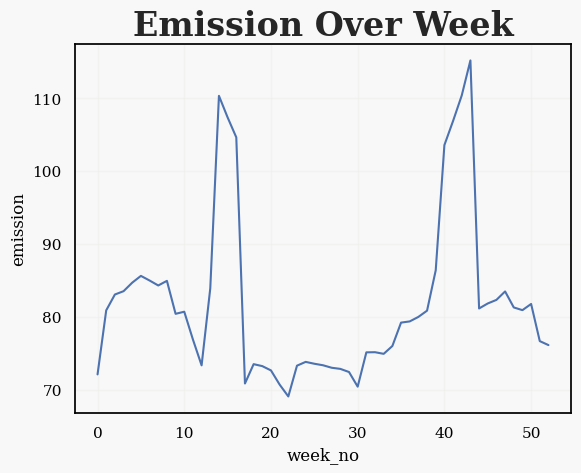

In [8]:
# line plot for emision 
sns.lineplot(data = train, x = 'week_no', y = 'emission', errorbar = None)
    
plt.title('Emission Over Week', fontsize = 24, fontweight = 'bold')
plt.show()

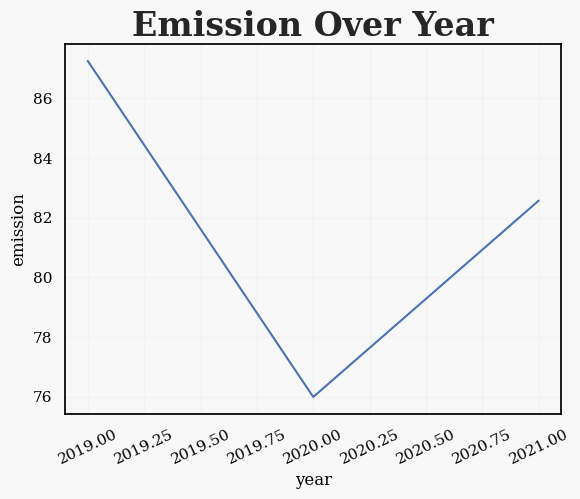

In [9]:
sns.lineplot(data = train, x = 'year', y = 'emission', errorbar = None)
    
plt.title('Emission Over Year', fontsize = 24, fontweight = 'bold')
plt.xticks(rotation = 25)
plt.show()

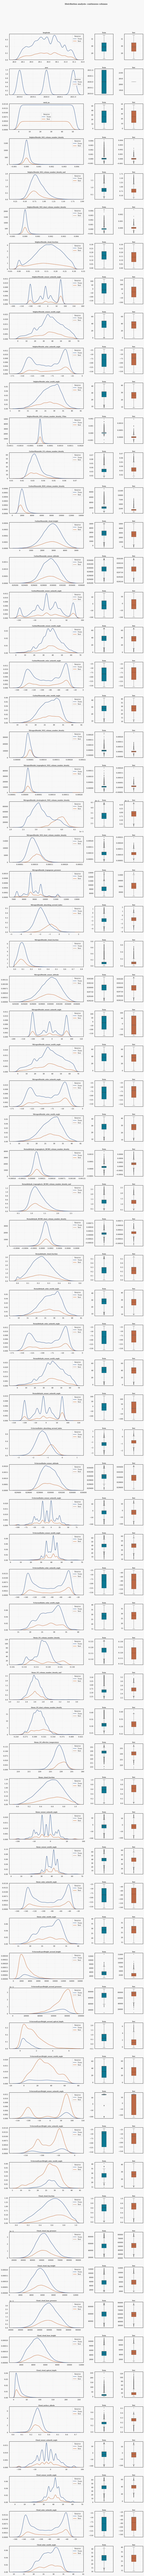

In [10]:
num = train.columns.tolist()[1:-1]
df = pd.concat([train[num].assign(Source = 'Train'), 
                test[num].assign(Source = 'Test')], 
               axis=0, ignore_index = True);

fig, axes = plt.subplots(len(num), 3 ,figsize = (16, len(num) * 4.2), 
                         gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20]});

for i,col in enumerate(num):
    ax = axes[i,0];
    sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', ax = ax, linewidth = 2.1)
    ax.set_title(f"\n{col}",fontsize = 9, fontweight= 'bold');
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75);
    ax.set(xlabel = '', ylabel = '');

    ax = axes[i,1];
    sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25,saturation = 0.90, linewidth = 0.90, fliersize= 2.25, color = '#037d97',
                ax = ax);
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Train",fontsize = 9, fontweight= 'bold');

    ax = axes[i,2];
    sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, fliersize= 2.25,
                saturation = 0.6, linewidth = 0.90, color = '#E4591E',
                ax = ax); 
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Test",fontsize = 9, fontweight= 'bold');


plt.suptitle(f"\nDistribution analysis- continuous columns\n",fontsize = 12, fontweight= 'bold',
             y = 0.89, x = 0.57);
plt.tight_layout();
plt.show();

<p style="font-family: consolas; font-size: 16px;">⚪ I noticed that the difference in distribution between the training dataset and the test dataset seems to be a bit large, which could lead to generalization problems.</p>
<p style="font-family: consolas; font-size: 12px;">🔴 注意到，训练数据集和测试数据集的分布差别似乎有点大，这可能会导致泛化问题。</p>

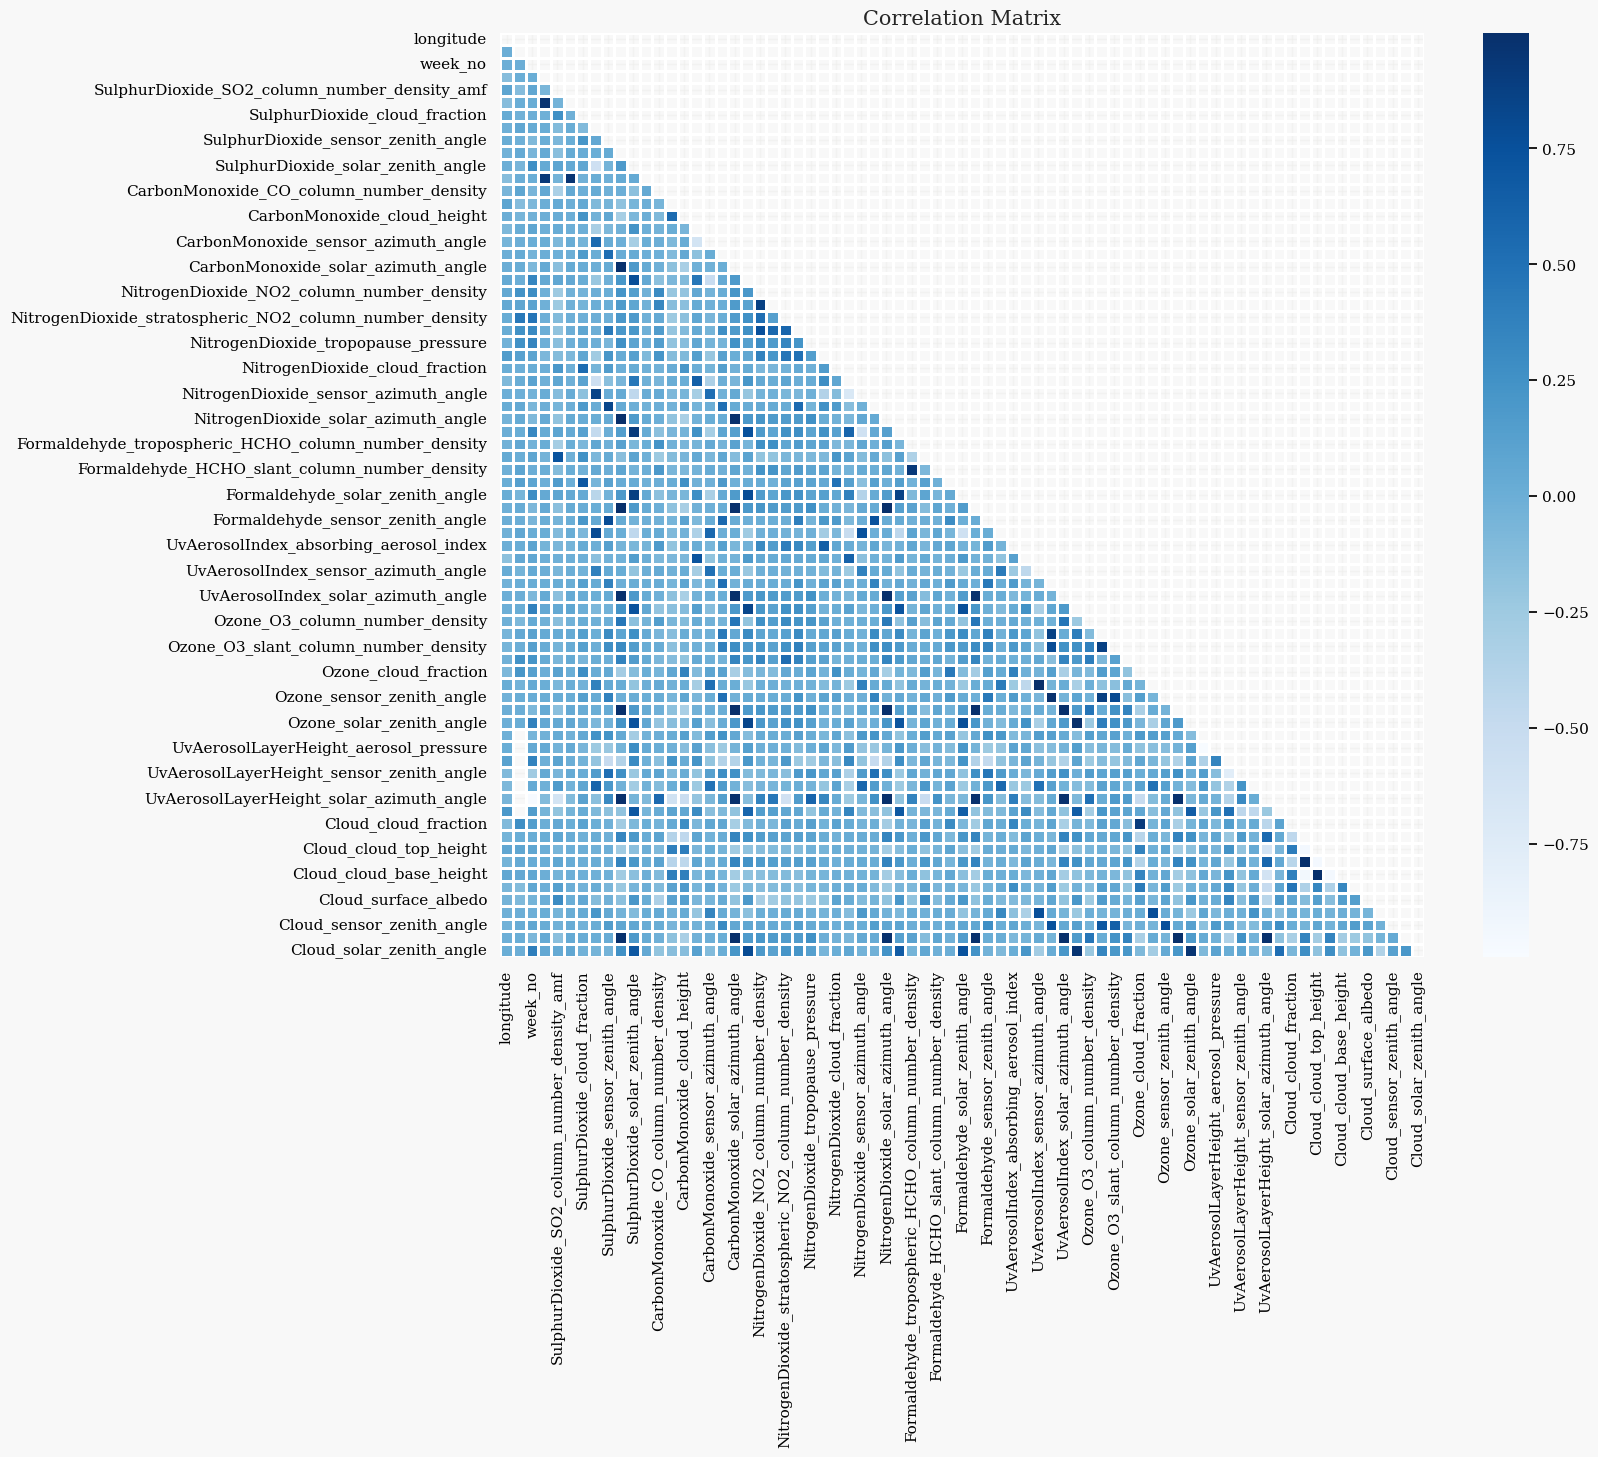

In [11]:
# Correlation

corr_matrix = train[num].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()

<p style="font-family: consolas; font-size: 16px;">⚪ I have noticed a strong correlation between some of the features. I might consider removing them.</p>
<p style="font-family: consolas; font-size: 12px;">🔴 有一些特征相关性较强。需要考虑共线性问题。</p>

<a id="3"></a>
# <b> 3. Data preprocecssing </b>

In [12]:
# add feature
train['covid_flag'] = np.where((train['year'] == 2020) & (train['week_no'] >= 11) & (train['week_no'] <= 40), 1, 0)
test['covid_flag'] = 0

train['week_no_sin'] = np.sin(train['week_no']*(2*np.pi/52))
train['week_no_cos'] = np.cos(train['week_no']*(2*np.pi/52))

test['week_no_sin'] = np.sin(test['week_no']*(2*np.pi/52))
test['week_no_cos'] = np.cos(test['week_no']*(2*np.pi/52))

In [13]:
def feature_preprocessing(df):
    # drop features with more than 50% nan.
    missing_ratios = df.isnull().mean()
    columns_to_drop = missing_ratios[missing_ratios > 0.5].index
    df = df.drop(columns_to_drop, axis=1)
    df = df.fillna(df.mean())
    # scalar
    sc = StandardScaler()
    for i in df.columns:
        if i not in ['week_no', 'covid_flag','latitude','longitude','emission']:
            df[i] = sc.fit_transform(df[i].values.reshape(-1,1))
    return df

train = feature_preprocessing(train)
test = feature_preprocessing(test)

<a id="4"></a>
# <b> 4. Feature Engineering </b>

From @DR.ALVINLEENH and @LUCAS BOESEN

<p style="font-family: consolas; font-size: 16px;">⚪ I chose 5,10,15 features respectively and the RMSE could only reach a maximum of 44, so I considered using the method in the high score notebook: constructing features using kmeans clustering.</p>
<p style="font-family: consolas; font-size: 12px;">🔴 我分别选择了5,10,15个特征，RMSE最高只能达到44，因此我考虑使用高分notebook中的方法：使用kmeans聚类构建特征。</p>

In [14]:
def calculateRMSE(x,y,features,model):
    for i,val in enumerate(x.columns):
        if val not in features:
            x = x.drop(columns=val)
    X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.2, random_state=42)
    clf = LGBMRegressor().fit(X_train,y_train)
    prediction = clf.predict(X_val)
    loss = np.sqrt(mean_squared_error(y_val,prediction))
    
    print(f"{model} has RMSE = {loss}")

<a id="4.0"></a>
## <b> 4.0 Creat Features </b>

In [15]:
# Clustering by emission mean
# 根据地区的排放量进行聚类
cluster_train = train.groupby(by=['latitude', 'longitude'], as_index=False)['emission'].mean()
model = KMeans(n_clusters=5)
model.fit(cluster_train)
cluster_train['kmeans_group'] = model.predict(cluster_train)

In [16]:
# check if emission is 0
cluster_train['is_zero'] = cluster_train['emission'].apply(lambda x: 1 if x==0 else 0)

# Distance to the highest emission location
# 找到同一地区的历史最高排放量，并计算距离它的距离 
max_lat_lon_emission = cluster_train.loc[cluster_train['emission']==cluster_train['emission'].max(), ['latitude', 'longitude']]
cluster_train['distance_to_max_emission'] = cluster_train.apply(lambda x: hs.haversine((x['latitude'], x['longitude']), (max_lat_lon_emission['latitude'].values[0], max_lat_lon_emission['longitude'].values[0])), axis=1)

In [17]:
train = train.merge(cluster_train[['latitude', 'longitude', 'kmeans_group', 'is_zero', 'distance_to_max_emission']], on=['latitude', 'longitude'])
test = test.merge(cluster_train[['latitude', 'longitude', 'kmeans_group', 'is_zero', 'distance_to_max_emission']], on=['latitude', 'longitude'])

In [18]:
test.head()

latitude  longitude  year  week_no  \
0     -0.51      29.29   0.0        0   
1     -0.51      29.29   0.0        1   
2     -0.51      29.29   0.0        2   
3     -0.51      29.29   0.0        3   
4     -0.51      29.29   0.0        4   

   SulphurDioxide_SO2_column_number_density  \
0                                  0.000000   
1                                  2.186870   
2                                  0.726706   
3                                  1.663142   
4                                 -1.633886   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                 -7.640307e-16   
1                                 -6.978477e-01   
2                                 -1.290077e+00   
3                                 -6.582605e-01   
4                                 -1.459230e+00   

   SulphurDioxide_SO2_slant_column_number_density  \
0                                   -1.153826e-17   
1                                    2.087795e+00   
2                                    6.591437e-01   
3                                    1.594243e+00   
4                                   -1.314821e+00   

   SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  \
0                       0.000000                         3.059265e-17   
1                      -2.015858                         1.152869e+00   
2                      -0.859355                        -8.844149e-01   
3                       0.895006                         1.082781e+00   
4                       0.943140                         1.152037e+00   

   SulphurDioxide_sensor_zenith_angle  SulphurDioxide_solar_azimuth_angle  \
0                        5.804386e-16                            0.000000   
1                       -1.680655e+00                           -1.979031   
2                        3.034561e-01                           -1.862996   
3                        1.853390e+00                           -2.378633   
4                       -1.676945e+00                           -1.827289   

   SulphurDioxide_solar_zenith_angle  \
0                           0.000000   
1                           0.590406   
2                           0.822053   
3                          -0.827101   
4                          -0.322906   

   SulphurDioxide_SO2_column_number_density_15km  \
0                                       0.000000   
1                                       2.394179   
2                                       0.783525   
3                                       1.400454   
4                                      -1.241902   

   CarbonMonoxide_CO_column_number_density  \
0                                 0.000000   
1                                 0.737724   
2                                 0.761459   
3                                 1.061778   
4                                 0.982945   

   CarbonMonoxide_H2O_column_number_density  CarbonMonoxide_cloud_height  \
0                             -4.198072e-16                     0.000000   
1                             -2.071820e-01                     0.148014   
2                              1.530282e+00                     0.647080   
3                              1.930043e-01                     0.555878   
4                             -9.114941e-01                    -0.549279   

   CarbonMonoxide_sensor_altitude  CarbonMonoxide_sensor_azimuth_angle  \
0                   -1.319386e-12                             0.000000   
1                   -1.561344e+00                             0.610382   
2                   -1.918268e+00                             0.383907   
3                   -1.341961e+00                            -0.175731   
4                   -4.576903e-01                            -0.746543   

   CarbonMonoxide_sensor_zenith_angle  CarbonMonoxide_solar_azimuth_angle  \
0                            0.000000                       -4.124697e-16   
1                           -1.052973                     

In [19]:
dt1 = train[train.year == 2020].groupby(['week_no'], as_index=False)['emission'].mean()
dt2 = train[train.year != 2020].groupby(['week_no'], as_index=False)['emission'].mean()
dt = dt1 / dt2
dt['mean'] = dt.mean(axis=1)
train['ratio_2020'] = 1
train.loc[train['year']==2020, 'ratio_2020'] = train[train['year']==2020].week_no.map(dt['mean'])
test['ratio_2020'] = 1

In [20]:
X = train.drop('emission',axis=1)
Y = train['emission']

# This data is for FS
# 经过预处理的数据将用在特征选择
train_fs = pd.concat([X,Y],axis = 1)

<a id="4.1"></a>
## <b> 4.1 Pearson Correlation </b>

In [21]:
trainCorr = train_fs.corr()
threshold = 0.05
corr=abs(trainCorr['emission'])
result = corr[corr>threshold]
result.sort_values(ascending=False)

emission                    1.000000
longitude                   0.102746
is_zero                     0.100175
distance_to_max_emission    0.076962
kmeans_group                0.050426
Name: emission, dtype: float64

<p style="font-family: consolas; font-size: 16px;">⚪ I'm trying to find features that correlate with the target variable, but due to some preprocessing and normalization I've done, the current features don't correlate very well with the target variable.</p>
<p style="font-family: consolas; font-size: 12px;">🔴 我们想找到与目标变量相关的特征，但是由于我们进行了一些预处理和标准化，目前的特征与目标变量相关性并不高。</p>

In [22]:
featurePC = X.drop(['longitude', 'kmeans_group', 'is_zero', 'distance_to_max_emission'],axis=1).columns
calculateRMSE(X,Y,featurePC,'Pearson Correlation')

Pearson Correlation has RMSE = 81.42131523037699


In [23]:
featurePC = X.drop(['longitude'],axis=1).columns
calculateRMSE(X,Y,featurePC,'Pearson Correlation')

Pearson Correlation has RMSE = 22.298147896445833


<p style="font-family: consolas; font-size: 16px;">⚪ Key point: The features we constructed do not have a strong linear correlation with emission, but that does not mean they are not useful.</p>
<p style="font-family: consolas; font-size: 12px;">🔴 我们构建的特征与emission没有很强的线性相关性，但这不代表它们没有用。</p>

<a id="4.2"></a>
## <b> 4.2 Step Forward Selection </b>

In [24]:
# from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# X_train, X_val, y_train, y_val = train_test_split(X,Y,test_size=0.2, random_state=42)
# clf = LGBMRegressor()
# sfs_1 = sfs(clf,k_features=10,forward=True,verbose=1, cv=5)
# sfs_1 = sfs_1.fit(X_train, y_train)

In [25]:
# feat_cols = list(sfs_1.k_feature_idx_)
# featureSFS = X.columns[feat_cols].tolist()

featureSFS = ['latitude',
 'longitude',
 'year',
 'week_no',
 'CarbonMonoxide_sensor_azimuth_angle',
 'Cloud_solar_azimuth_angle',
 'week_no_sin',
 'kmeans_group',
 'is_zero',
 'distance_to_max_emission']

print("Selected features:", featureSFS)
calculateRMSE(X,Y,featureSFS,'Step Forward Selection')

Selected features: ['latitude', 'longitude', 'year', 'week_no', 'CarbonMonoxide_sensor_azimuth_angle', 'Cloud_solar_azimuth_angle', 'week_no_sin', 'kmeans_group', 'is_zero', 'distance_to_max_emission']
Step Forward Selection has RMSE = 21.008773022083336


<p style="font-family: consolas; font-size: 16px;">⚪ The SFS feature achieves an RMSE of 20.98.</p>
<p style="font-family: consolas; font-size: 12px;">🔴 SFS特征能达到20.98的RMSE。</p>

<a id="4.3"></a>
## <b> 4.3 Recursive Feature elimination </b>

In [26]:
from sklearn.feature_selection import RFE

clf = LGBMRegressor()
rfe = RFE(clf)
X_rfe = rfe.fit_transform(X,Y)
clf.fit(X_rfe,Y)
cols = list(X.columns)
temp = pd.Series(rfe.support_,index = cols)

In [27]:
# featureRFE = temp[temp==True].index.tolist()
# print("Selected features: ",featureRFE)

featureRFE = ['latitude', 'longitude', 'year', 'week_no', 'SulphurDioxide_solar_zenith_angle', 'CarbonMonoxide_CO_column_number_density', 'CarbonMonoxide_H2O_column_number_density', 'CarbonMonoxide_solar_azimuth_angle', 'CarbonMonoxide_solar_zenith_angle', 'NitrogenDioxide_tropospheric_NO2_column_number_density', 'NitrogenDioxide_stratospheric_NO2_column_number_density', 'NitrogenDioxide_tropopause_pressure', 'Formaldehyde_solar_azimuth_angle', 'UvAerosolIndex_sensor_altitude', 'UvAerosolIndex_sensor_azimuth_angle', 'UvAerosolIndex_sensor_zenith_angle', 'UvAerosolIndex_solar_azimuth_angle', 'UvAerosolIndex_solar_zenith_angle', 'Ozone_O3_column_number_density', 'Ozone_O3_column_number_density_amf', 'Ozone_O3_slant_column_number_density', 'Ozone_O3_effective_temperature', 'Ozone_cloud_fraction', 'Ozone_solar_azimuth_angle', 'Ozone_solar_zenith_angle', 'Cloud_cloud_top_pressure', 'Cloud_surface_albedo', 'Cloud_sensor_azimuth_angle', 'Cloud_sensor_zenith_angle', 'Cloud_solar_azimuth_angle', 'Cloud_solar_zenith_angle', 'covid_flag', 'week_no_sin', 'week_no_cos', 'kmeans_group', 'is_zero', 'distance_to_max_emission']
calculateRMSE(X,Y,featureRFE,'Recursive Feature Elimination')

Recursive Feature Elimination has RMSE = 21.38230248449274


<p style="font-family: consolas; font-size: 16px;">⚪ The RFE feature achieves an RMSE of 21.17.</p>
<p style="font-family: consolas; font-size: 12px;">🔴 RFE特征能达到21.17的RMSE。</p>

<a id="5"></a>
# <b> 5. Baseline Modeling </b>

<p style="font-family: consolas; font-size: 16px;">⚪ I selected some features to go into the model.</p>
<p style="font-family: consolas; font-size: 12px;">🔴 我选择了一些特征进入模型。</p>

In [28]:
# selected_feats = ['kmeans_group', 'longitude', 'week_no', 'distance_to_max_emission', 'latitude', 'ratio_2020']
# selected_feats = featureSFS
selected_feats = featureRFE
X = train[selected_feats]
Y = Y

test = test[selected_feats]

In [29]:
xgb_cv_scores, xgb_preds = list(), list()
lgbm_cv_scores, lgbm_preds = list(), list()
# ens_cv_scores, ens_preds = list(), list()

kf = KFold(n_splits=5, random_state=42, shuffle=True)

for i, (train_ix, test_ix) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
    print('---------------------------------------------------------------')
    
    ## XGBoost
    xgb_md = XGBRegressor().fit(X_train, Y_train)
    xgb_pred = xgb_md.predict(X_test)   
    xgb_score_fold = np.sqrt(mean_squared_error(Y_test, xgb_pred))
    print('Fold', i+1, '==> XGBoost oof RMSE score is ==>', xgb_score_fold)
    xgb_cv_scores.append(xgb_score_fold)
    
    xgb_pred_test = xgb_md.predict(test)
    xgb_preds.append(xgb_pred_test)
    
    ## LGBM
    lgbm_md = LGBMRegressor(n_estimators = 1000,
                           max_depth = 15,
                           learning_rate = 0.01,
                           num_leaves = 105,
                           reg_alpha = 0.1, #0.3
                           reg_lambda = 0.1,
                           subsample = 0.7,
                           colsample_bytree = 0.8).fit(X_train, Y_train)
    lgbm_pred = lgbm_md.predict(X_test) 
    lgbm_score_fold = np.sqrt(mean_squared_error(Y_test, lgbm_pred))
    print('Fold', i+1, '==> LGBM oof RMSE score is ==>', lgbm_score_fold)
    lgbm_cv_scores.append(lgbm_score_fold)
    
    lgbm_pred_test = lgbm_md.predict(test)
    lgbm_preds.append(lgbm_pred_test) 
    
print('---------------------------------------------------------------')
print('Average RMSE of XGBoost model is:', np.mean(xgb_cv_scores))
print('Average RMSE of LGBM model is:', np.mean(lgbm_cv_scores))

---------------------------------------------------------------
Fold 1 ==> XGBoost oof RMSE score is ==> 19.622572339436125
Fold 1 ==> LGBM oof RMSE score is ==> 17.16370443901878
---------------------------------------------------------------
Fold 2 ==> XGBoost oof RMSE score is ==> 15.085567788621642
Fold 2 ==> LGBM oof RMSE score is ==> 12.832558754464442
---------------------------------------------------------------
Fold 3 ==> XGBoost oof RMSE score is ==> 24.704120430635513
Fold 3 ==> LGBM oof RMSE score is ==> 22.34534737533322
---------------------------------------------------------------
Fold 4 ==> XGBoost oof RMSE score is ==> 14.464190034490187
Fold 4 ==> LGBM oof RMSE score is ==> 12.04696730103946
---------------------------------------------------------------
Fold 5 ==> XGBoost oof RMSE score is ==> 14.386920078079998
Fold 5 ==> LGBM oof RMSE score is ==> 12.523106433796908
---------------------------------------------------------------
Average RMSE of XGBoost model is: 

## <center style="font-family: consolas; font-size: 32px; font-weight: bold;">CV Scores</center>

| Feature | XGB CV Score | LGBM CV Score|
|---------|--------------|--------------|
| 6 Features | 19.92 | 19.66 |
| Feature SFS | 14.62 | 15.72 |
| Feature RFE | 16.90 | 16.97 |


<a id="6"></a>
# <b> 6. No ML </b>
From @OSCAR AGUILAR

<p style="font-family: consolas; font-size: 16px;">⚪ While I was racking my brain for hyperparameters, I came across this notebook. it achieved a score of 33.52 without using machine learning methods.</p>
<p style="font-family: consolas; font-size: 12px;">🔴 在我绞尽脑汁寻找超参数的时候，我看到了这个notebook。它没有使用机器学习方法就达到了33.52的分数。</p>

<p style="font-family: consolas; font-size: 16px;">⚪ In this method, it groups the data in the training set based on geographic location and date. Then the data from the training set is put directly into the test set...</p>
<p style="font-family: consolas; font-size: 12px;">🔴 在这个方法中，它将训练和测试集中的数据根据地理位置和日期进行分组，然后直接把训练集数据赋值给了测试集。太逆天了...这居然比用了模型的分还高...</p>

<p style="font-family: consolas; font-size: 16px;">⚪ Assuming that emissions in each region follow a fixed cycle and seasonality, it is true that a direct copy of the previous data would not have much error.</p>
<p style="font-family: consolas; font-size: 12px;">🔴 假如每个地区的排放量遵循一个固定周期和季节性，确实直接copy之前的数据不会有太大的误差。</p>


<p style="font-family: consolas; font-size: 16px;">⚪ <b>train_agg</b> shows the weekly emissions for each location.</p>
<p style="font-family: consolas; font-size: 12px;">🔴 <b>train_agg</b> 显示了各个地址每周的排放量。</p>



In [30]:
test_noml = pd.read_csv('/kaggle/input/playground-series-s3e20/test.csv')
train['location'] = [str(train['latitude'][i]) + '_' + str(train['longitude'][i]) for i in range(0, train.shape[0])]
test_noml['location'] = [str(test_noml['latitude'][i]) + '_' + str(test_noml['longitude'][i]) for i in range(0, test_noml.shape[0])]

train_agg = pd.DataFrame(train.groupby(['location', 'week_no'])['emission'].mean()).reset_index()
train_agg.head()

location  week_no  emission
0  -0.51_29.29        0  3.608051
1  -0.51_29.29        1  4.016319
2  -0.51_29.29        2  4.138755
3  -0.51_29.29        3  4.184737
4  -0.51_29.29        4  4.247569

In [31]:
test_out = test_noml[['ID_LAT_LON_YEAR_WEEK', 'location', 'week_no']].copy()
test_out = pd.merge(test_out, train_agg, on = ['location', 'week_no'], how = 'left')
test_out.drop(columns = ['location', 'week_no'], axis = 1, inplace = True)
test_out.head()

ID_LAT_LON_YEAR_WEEK  emission
0  ID_-0.510_29.290_2022_00  3.608051
1  ID_-0.510_29.290_2022_01  4.016319
2  ID_-0.510_29.290_2022_02  4.138755
3  ID_-0.510_29.290_2022_03  4.184737
4  ID_-0.510_29.290_2022_04  4.247569

<a id="7"></a>
# <b> 7. Submission </b>

In [32]:
submission_noml = test_out.copy()
submission_xgb = submission.copy()
submission_lgb = submission.copy()

submission_xgb['emission'] = xgb_md.predict(test)
submission_lgb['emission'] = lgbm_md.predict(test)

submission_xgb.to_csv('/kaggle/working/xgb_submission.csv', index=False)
submission_lgb.to_csv('/kaggle/working/lgb_submission.csv', index=False)
submission_noml.to_csv('/kaggle/working/noml_submission.csv', index = False)

<p style="font-family: consolas; font-size: 16px;">⚪ If you like it, please upvote it!</p>